# MACID tutorial

In [ ]:
# helpful extensions
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60
# importing necessary libraries
try:
    import pycid
except ModuleNotFoundError:
    import sys

    !{sys.executable} -m pip install pycid  # or  !{sys.executable} -m pip install git+https://github.com/causalincentives/pycid for the latest development version
    import pycid

import numpy as np

Autosaving every 60 seconds


# Table of contents
1. [Introduction to MA(C)IDs and MA(C)IMs](#intro)
2. [MA(C)ID subgames](#subgame)
3. [Multi-agent Influence Models (MAIMs)](#maim)
4. [Nash Equilibria in MAIMs](#ne)
5. [Subgame Perfect Equilbria in MAIMs](#spe)

If you'd prefer to open this notebook in Google Colab, cling the following link:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/causalincentives/pycid/blob/master/notebooks/MACID_Basics_Tutorial.ipynb)


# 1) Introduction to MA(C)IDs and MA(C)IMs <a name="intro"></a>

In the CID tutorial, we showed how to instantiate single-agent causal influence diagrams (CIDs) and models (CIMs). In this section, we demonstrate how to use our codebase for multi-agent causal influence diagrams (MACIDs)

<div class="alert alert-block alert-info">
<b>Definition:</b> 
A <b>multi-agent influence diagram (MAID)</b> (Hammond et al, 2021) is a triple $(\textbf{N}, \textbf{V}, \textbf{E})$, where:
    
 - $\textbf{N} = \{1,\dots,n\}$ is a set of agents.
 - $(\textbf{V}, \textbf{E})$ is a directed acyclic graph (DAG) with a set of vertices $\textbf{V}$ connected by directed edges $\textbf{E} \subseteq \textbf{V} \times \textbf{V}$. These vertices are partitioned into $\textbf{D}$, $\textbf{U}$, and $\textbf{X}$, which correspond to decision, utility, and chance nodes respectively. $\textbf{D}$ and $\textbf{U}$ are in turn partitioned into $\{\textbf{D}^i\}_{i\in \textbf{N}}$ and $\{\textbf{U}^i\}_{i\in \textbf{N}}$ corresponding to their association with a particular agent $i \in \textbf{N}$.
   
</div> 


<div class="alert alert-block alert-info">
<b>Definition:</b> A <b>multi-agent influence model (MAIM)</b> (Hammond et al, 2021) is a tuple $(\textbf{N}, \textbf{V}, \textbf{E}, \theta)$ where $(\textbf{N}, \textbf{V}, \textbf{E})$ is a MAID and:

- $\theta \in \Theta$ is a particular parametrisation over the nodes in the graph specifying a finite domain $\textbf{dom}(V)$ for each node $V \in \textbf{V}$, real-valued domains $\textbf{dom}(U) \subset \mathbb{R}$ for each $U \in \textbf{U}$, and a set of conditional probability distributions (CPDs) $\Pr(\textbf{V} \mid \textbf{Pa}_V)$ for every chance and utility node. Taken together, the CPDs form a partial distribution $\Pr(\textbf{X},\textbf{U} : \textbf{D}) = \prod_{V \in \textbf{V} \setminus \textbf{D}} \Pr(V \mid \textbf{Pa}_V)$ over the variables in the MAID.
 - The value $u \in \textbf{dom}(U)$ of a utility node is a deterministic function of the values of its parents $\textbf{pa}_U \in \textbf{dom}(\textbf{Pa}_U)$.
</div> 

Note: these definitions define MAIDs and MAIMs as opposed to MACIDs and MACIMs. A MACID is a multi-agent causal influence diagram, which differs from a MAID because the edges now represent every causal relationship between the random variables chosen to be endogenous variables in the model. However, because MACIDs subsume MAIDs (in the sense of Pearl's `causal hierarchy` (Pearl, 2009)), meaning that everything we can do in a MAID, we can also do in a MACID, for the purpose of this codebase treat these models the same.

As we did in the CID basics tutorial, we'll start by showing how to instantiate a MACID showcasing some useful methods. We'll then show how to parameterise them as MACIMs. 

__Job Hiring Example:__ _A company employs an AI system to automate their hiring process. A naturally hard-working or naturally lazy worker wants a job at this company and believes that a university degree will increase their chance of being hired; however, they also know that they will suffer an opportunity cost from three years of studying. A hard-worker will cope better with a university workload than a lazy worker. The algorithm must decide, on behalf of the company, whether to hire the worker. The company wants to hire someone who is naturally hard-working, but the algorithm can't observe the worker's temperament directly, it can only infer it indirectly through whether or not the worker attended university._

A hospital employs an AI system to automate a procurement process. A company wants to tender a contract to the hospital for the supply of some medical equipment. Beforehand, they can choose whether or not to get independent accreditation to signal that their equipment is of high not poor quality, but doing so requires a cost (that is greater if the product is indeed poor). The AI system must decide, on behalf of the hospital, whether to accept the company's offer. The hospital only wants to sign a contract with a company that will supply high quality equipment, but the AI system can't observe the quality of the equipment directly, it can only infer it indirectly through whether or not the company has independent accreditation. 


does not know the quality of the company's goods, it can only observe whether the company has been accredited or not, but it must decide 







We can construct a MACID for this example where:

- X = whether the worker is naturally hard working or lazy (chance node)
- D1 and U1 correspond to the worker's decision whether or not to go to university (and their utility)
- D2 and U2 correspond to the algorithm's decision whether or not to hire the worker (and the company's utility)

In [ ]:
macid = pycid.MACID(
    [
        ("X", "D1"),  # specifies the MAICD's nodes and edges.
        ("X", "U2"),
        ("X", "U1"),
        ("D1", "D2"),
        ("D1", "U1"),
        ("D2", "U1"),
        ("D2", "U2"),
    ],
    # specifies each agent's decision and utility nodes.
    agent_decisions={1: ["D1"], 2: ["D2"]},
    agent_utilities={1: ["U1"], 2: ["U2"]},
)

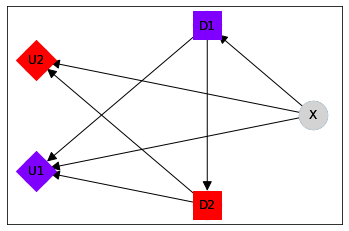

In [ ]:
macid.draw()

Consistent with CIDs, chance nodes are drawn as circles, decision nodes are drawn as rectangles, and utility nodes are drawn as diamonds. Because we now have more than one player, we reserve colouring to denote agent membership; each agent of the game is assigned a unique colour.

In Hammond et al (2021), we introduced the graphical criterion _r-reachability_ to determine whether another decision node is strategically relevant or a chance node is probabilistically relevant to a decision node (see paper).

<div class="alert alert-block alert-info">
<b>Definition:</b> A node $V$ is <b>r-reachable</b> from a decision $D \in \textbf{D}^i$ in a MAID, $\mathcal{M} = (\textbf{N}, \textbf{V}, \textbf{E})$, if a newly added parent $\hat V$ of $V$ satisfies $\hat V \not\perp \textbf{U}^i \cap \textbf{Desc}_{D} \mid \textbf{Fa}_{D}$. 
</div> 

In [ ]:
macid.is_r_reachable("D1", "D2")

True

In [ ]:
macid.is_r_reachable("D2", "D1")

True

In [ ]:
nodes = macid.nodes()

[x for x in nodes if macid.is_r_reachable("D1", x)]

['U1', 'D2']

Each decision strategically relies on the other. The worker would be better off knowing the company’s hiring policy before deciding whether or not to go to university, and the algorithm would also be better off knowing the worker’s policy because it doesn’t know the worker’s temperament (lazyor hard-working). 

Relevance graphs show this visually: 

<div class="alert alert-block alert-info">
<b>Definition:</b> The directed <b> relevance graph </b> for $\mathcal{M}$, denoted by $Rel(\mathcal{M}) = (\textbf{D}, \textbf{E}_{Rel})$, is a graph where $\textbf{D}$ is the set of $\mathcal{M}$'s decision nodes connected by directed edges $\textbf{E}_{Rel} \subseteq \textbf{D} \times \textbf{D}$. There is a directed edge from $D_j \rightarrow D_k$ if and only if $D_k$ is r-reachable from $D_j$. 
</div> 

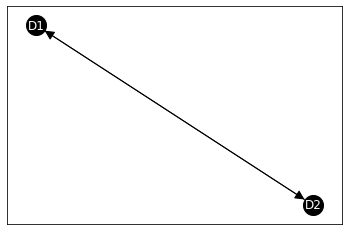

In [ ]:
pycid.RelevanceGraph(macid).draw()  # the relevance graph for this example is cyclic.

# 2) MA(C)ID subgames <a name="subgame"></a>

In Hammond et al (2021), we defined MAID subgames which, when parameterised as MAIMs, expose parts of the game that can be solved independently.


<div class="alert alert-block alert-info">
<b>Definition:</b> A <b> subgame base </b> for a MAID $(\textbf{N}, \textbf{V}, \textbf{E})$ is a subset $\textbf{V'}\subseteq \textbf{V}$ such that:

- For any $X,Y\in \textbf{V}'$ and any directed path $X \to \cdots \to Y$ in $\mathcal{M}$, all nodes on the path are also in $\textbf{V'}$.
- $\textbf{V}'$ is closed under r-reachability, i.e.\ if a node $Z$ is r-reachable from a decision $D\in \textbf{V'}$, then $Z$ is also in $\textbf{V'}$.
</div> 






<div class="alert alert-block alert-info">
<b>Definition:</b> Let $\mathcal{M} = (\textbf{N}, \textbf{V}, \textbf{E})$ be a MAID,
    and let $\textbf{V'}\subseteq \textbf{V}$ be a subgame base. The <b>MAID subgame</b> corresponding to $\textbf{V'}$, is a new MAID $\mathcal{M}'=(\textbf{N'}, \textbf{V'}, \textbf{E}')$  where:

- $\textbf{N'} = \{i \in \textbf{N} \mid \textbf{D}^i \cap \textbf{V'} \neq \varnothing \}$, the players restricted to $\textbf{V'}$.
- $\textbf{V'}$ is partitioned into $\textbf{D'} = \textbf{D}\cap \textbf{V'}$, $\textbf{U'} = \textbf{U} \cap \textbf{Desc}_{\textbf{D'}}$, and $\textbf{X'} = \textbf{V'} \setminus (\textbf{D'} \cap \textbf{U'})$.
- $\textbf{E}'$ is the subset of edges in $\textbf{E}$ that connect two nodes in $\textbf{V'}$. 
</div> 

<div class="alert alert-block alert-info">
    <b>Definition:</b> The <b> MAIM subgame </b> of a MAIM $(\textbf{N}, \textbf{V}, \textbf{E}, \theta)$ corresponding to a subset $\textbf{V'}\subseteq \textbf{V}$ and an instantiation $\textbf{y}$ of the nodes $\textbf{Y} = \textbf{V}\setminus \textbf{V'}$, is the modified MAIM $(\textbf{N'}, \textbf{V'}, \textbf{E}', \theta')$ where:
 
- $(\textbf{N'}, \textbf{V'}, \textbf{E}')$ is the MAID subgame corresponding to $\textbf{V'}$.
- $\theta'$ is like $\theta$, restricted to nodes in $\textbf{V'}$. If a node $X\in \textbf{V'}$ has some parents outside of $\textbf{V'}$ (i.e.\ in $\textbf{Y}$) then $\Pr'(X\mid \textbf{pa}'_X) = \Pr(X\mid \textbf{pa}'_X, \textbf{y}')$, where $\textbf{Pa}'_X=\textbf{Pa}_X\cap \textbf{V'}$, $\textbf{Y}' = \textbf{Pa}_X\cap \textbf{Y}$, $\textbf{Pr}$ is the CPD of $X$ in $\theta$, and $\textbf{Pr}'$ becomes the CPD of $X$ in $\theta'$.
</div> 

MAID subgames can also be defined via the strongly connected components of the the MAID's relevance graph. 

Recall that an SCC is a subgraph containing a directed path between every pair of nodes. A maximal SCC is an SCC that is not a strict subset of any other SCC:

<div class="alert alert-block alert-info">
    <b>Definition:</b> For a given MAID $\mathcal{M} = (\textbf{N}, \textbf{V}, \textbf{E})$, let $\textbf{C}$ be the set of maximal SCCs of its relevance graph $Rel(\mathcal{M})$. The <b>condensed relevance graph </b> of $\mathcal{M}$ is the directed graph $ConRel(\mathcal{M}) = (\textbf{C}, \textbf{E}_{ConRel})$. There is an edge $\textbf{C}_m \rightarrow \textbf{C}_l$ between $\textbf{C}_m, \textbf{C}_l\in\textbf{C}$ if and only if there exists $C_m\in \textbf{C}_m$ and $C_l\in \textbf{C}_l$ with and edge $C_m\to C_l$ in $Rel(\mathcal{M})$.
    
    
    
</div> 

Subgraphs of $ConRel(\mathcal{M})$ closed under descendants induce MAID subgames.

Consider the MACID below:

In [ ]:
macid = pycid.MACID(
    [
        ("X2", "U3"),
        ("X2", "D1"),
        ("D3", "U3"),
        ("D3", "U2"),
        ("D1", "U1"),
        ("D1", "U2"),
        ("D2", "U1"),
        ("D2", "U2"),
        ("D4", "U1"),
        ("D4", "D2"),
        ("D4", "U4"),
        ("X1", "D4"),
        ("X1", "U4"),
    ],
    agent_decisions={1: ["D1"], 2: ["D2"], 3: ["D3"], 4: ["D4"]},
    agent_utilities={1: ["U1"], 2: ["U2"], 3: ["U3"], 4: ["U4"]},
)

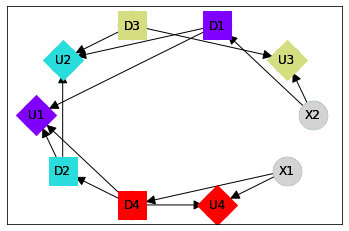

In [ ]:
macid.draw()

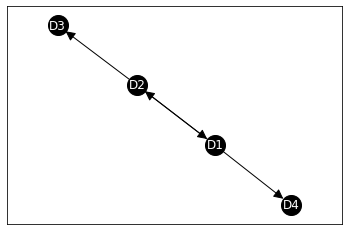

In [ ]:
pycid.RelevanceGraph(macid).draw()

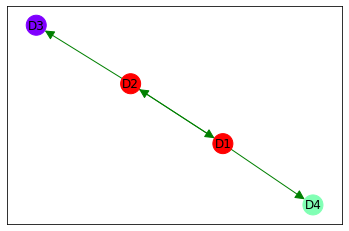

In [ ]:
pycid.RelevanceGraph(macid).draw_sccs()  # each SCC of the MACID's relevance graph is assigned a unique colour

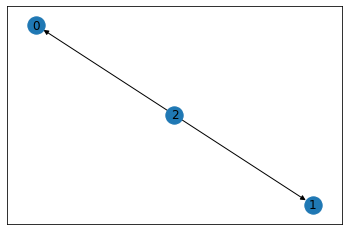

In [ ]:
pycid.CondensedRelevanceGraph(macid).draw()  # the condensed relevance graph is always acyclic.

In [ ]:
con_rel = pycid.CondensedRelevanceGraph(macid)

In [ ]:
con_rel.graph["mapping"]  # this tells you which SCC each decision node is in.

{'D3': 0, 'D4': 1, 'D1': 2, 'D2': 2}

In [ ]:
macid.decs_in_each_maid_subgame()  # this gives the set of decision nodes in each MAID subgame of the original MAID.

[{'D3'}, {'D4'}, {'D3', 'D4'}, {'D1', 'D2', 'D3', 'D4'}]

# 3) Multi-agent Influence Models (MAIMs) <a name="maim"></a>

Earlier, we explained that a MACIM is a parameterised MACID. To demonstrate this, we'll create a MAIM for The Prisoner's Dilemma.

This is a simultaneous symmetric two-player game with payoffs corresponding to the following normal
form game - the row player is agent 1 and the column player is agent 2:  
  

|    |Cooperate|Defect|
|-----|-----|-----| 
|Cooperate|-1,-1|-3,0|
|Defect|0,-3|-2,-2|


In [ ]:
macid = pycid.MACID(
    [("D1", "U1"), ("D1", "U2"), ("D2", "U2"), ("D2", "U1")],  # Specifiying the MACID for this example as before
    agent_decisions={1: ["D1"], 2: ["D2"]},
    agent_utilities={1: ["U1"], 2: ["U2"]},
)

d1_domain = ["c", "d"]  # specifying the domain of each decision variable
d2_domain = ["c", "d"]

agent1_payoff = np.array(
    [[-1, -3], [0, -2]]  # specifying the payoff matrices corresponding to the normal form representation
)  # of the game shown in the doc string.
agent2_payoff = np.transpose(agent1_payoff)


macid.add_cpds(
    D1=d1_domain,
    D2=d1_domain,
    U1=lambda D1, D2: agent1_payoff[d1_domain.index(D1), d2_domain.index(D2)],
    U2=lambda D1, D2: agent2_payoff[d1_domain.index(D1), d2_domain.index(D2)],
)

This is the same as how we parameterised CIDs as CIMs in the CID Basics Tutorial

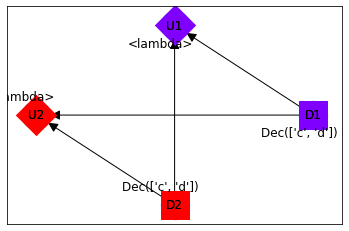

In [ ]:
macid.draw()

To find the expected utility that each player receives given a certain context):

In [ ]:
# macid.impute_fully_mixed_policy_profile() # we first must assign arbirtrary (but fully mixed) decision rules to all decision nodes
macid.expected_utility(context={"D1": "d", "D2": "c"}, agent=2)

-3.0

In [ ]:
macid.expected_utility({"D1": "d", "D2": "c"}, agent=2)

-3.0

# 4) Nash Equilibria in MAIMs <a name="ne"></a>

<div class="alert alert-block alert-info">
    <b>Definition:</b> A full policy profile $\pi$ is a <b>Nash equilibrium (NE)</b> in a MAIM $\mathcal{M}$ if, for every player $i \in \textbf{N}$, $\mathcal{U}^i_\mathcal{M}(\pi^i, \pi^{-i}) \geq \mathcal{U}^i_\mathcal{M}(\hat{\pi}^i, \pi^{-i})$ for all $\hat{\pi}^i \in \Pi^i$.
 </div>

To find all pure NE in this MACID:

In [ ]:
macid.get_all_pure_ne()

[[StochasticFunctionCPD<D1:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb4f1f70>> 
  {}  ->  d,
  StochasticFunctionCPD<D2:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb4f8160>> 
  {}  ->  d]]

This method return a list of all pure Nash equilbiria in the MACID. Each NE comes as a list of FunctionCPDs, one for each decision node in the MACID.

The following method matches each functionCPD in a list of CPDs with its corresponding decision node in the MACID (in other words, it "assigns" a partial or joint policy profile:

In [ ]:
all_pure_ne = macid.get_all_pure_ne()
macid.policy_profile_assignment(all_pure_ne[0])

{'D1': StochasticFunctionCPD<D1:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb4f8dc0>> 
 {}  ->  d,
 'D2': StochasticFunctionCPD<D2:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb4f8e50>> 
 {}  ->  d}

We can find the expected utility for each agent under this NE joint policy profile:

In [ ]:
macid.add_cpds(*all_pure_ne[0])

In [ ]:
macid.expected_utility({}, agent=1)

-2.0

In [ ]:
macid.expected_utility({}, agent=2)

-2.0

# 5) Subgame Perfect Equilbria in MAIMs <a name="spe"></a>

<div class="alert alert-block alert-info">
    <b>Definition:</b> A full policy profile $\pi$ is a <b>subgame perfect equilibrium (SPE)</b> in a MAIM $\mathcal{M}$ if $\pi$ is an NE in every MAIM subgame of $\mathcal{M}$.
 </div>

__Taxi Competition Example__ (Hammond et al, 2021) _Two autonomous taxis, operated by different companies, are driving along a road with two hotels located next to one another -- one expensive and one cheap. Each taxi must decide (one first, then the other) which hotel to stop in front of, knowing that it will likely receive a higher tip from guests of the expensive hotel. However, if both taxis choose the same location, this will reduce each taxi's chance of being chosen by that hotel's guests._

The payoffs are as folllows:

|    |Expensive|Cheap|
|-----|-----|-----| 
|Expensive|2,2|5,3|
|Cheap|3,5|1,1|

The MAID for this example is pretty simple:

In [ ]:
macid = pycid.MACID(
    [("D1", "D2"), ("D1", "U1"), ("D1", "U2"), ("D2", "U2"), ("D2", "U1")],
    agent_decisions={1: ["D1"], 2: ["D2"]},
    agent_utilities={1: ["U1"], 2: ["U2"]},
)

d1_domain = ["e", "c"]
d2_domain = ["e", "c"]
agent1_payoff = np.array([[2, 5], [3, 1]])
agent2_payoff = agent1_payoff.T

macid.add_cpds(
    D1=d1_domain,
    D2=d2_domain,
    U1=lambda D1, D2: agent1_payoff[d1_domain.index(D1), d2_domain.index(D2)],
    U2=lambda D1, D2: agent2_payoff[d1_domain.index(D1), d2_domain.index(D2)],
)

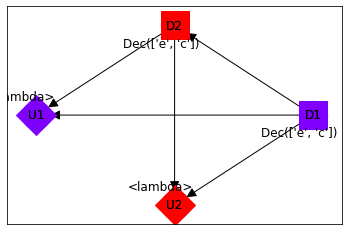

In [ ]:
macid.draw(node_label=None)

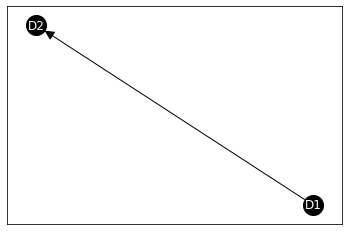

In [ ]:
pycid.RelevanceGraph(macid).draw()

This MACIM has three pure NE

In [ ]:
macid.get_all_pure_ne()

[[StochasticFunctionCPD<D1:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb6148b0>> 
  {}  ->  e,
  StochasticFunctionCPD<D2:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb614ee0>> 
  {'d1': 'c'}  ->  e
  {'d1': 'e'}  ->  c],
 [StochasticFunctionCPD<D1:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb6148b0>> 
  {}  ->  e,
  StochasticFunctionCPD<D2:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb614f70>> 
  {'d1': 'c'}  ->  c
  {'d1': 'e'}  ->  c],
 [StochasticFunctionCPD<D1:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb614c10>> 
  {}  ->  c,
  StochasticFunctionCPD<D2:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb614670>> 
  {'d1': 'c'}  ->  e
  {'d1': 'e'}  ->  e]]

It has one proper MAID subgame:

In [ ]:
macid.decs_in_each_maid_subgame()

[{'D2'}, {'D1', 'D2'}]

We can find the NE in the proper MAID subgame:

In [ ]:
macid.get_all_pure_ne_in_sg(decisions_in_sg=["D2"])

[[StochasticFunctionCPD<D2:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb6145e0>> 
  {'d1': 'c'}  ->  e
  {'d1': 'e'}  ->  c]]

To find all SPE in this MACIM:

In [ ]:
macid.get_all_pure_spe()

[[StochasticFunctionCPD<D2:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb626310>> 
  {'d1': 'c'}  ->  e
  {'d1': 'e'}  ->  c,
  StochasticFunctionCPD<D1:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb626ee0>> 
  {}  ->  e]]

Each player's expected utility under this SPE joint policy profile:

In [ ]:
macid.add_cpds(*macid.get_all_pure_spe()[0])

In [ ]:
macid.expected_utility({}, agent=1)

5.0

In [ ]:
macid.expected_utility({}, agent=2)

3.0

If we change the player 2's payoff matrix to:

In [ ]:
agent2_payoff = np.array([[2, 5], [3, 5]])
cpd_u2 = pycid.StochasticFunctionCPD(
    "U2", lambda D1, D2: agent2_payoff[d2_domain.index(D2), d1_domain.index(D1)], macid
)

There is now a tie-break where if the value of D1 is 'c', agent 2 is indifferent between each of their actions. This means that there is more than one SPE:

In [ ]:
macid.add_cpds(cpd_u2)

In [ ]:
macid.get_all_pure_spe()

[[StochasticFunctionCPD<D2:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb5484c0>> 
  {'d1': 'c'}  ->  e
  {'d1': 'e'}  ->  c,
  StochasticFunctionCPD<D1:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb548a60>> 
  {}  ->  e],
 [StochasticFunctionCPD<D2:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb548550>> 
  {'d1': 'c'}  ->  c
  {'d1': 'e'}  ->  c,
  StochasticFunctionCPD<D1:<function MACIDBase.pure_decision_rules.<locals>.produce_function.<locals>.<lambda> at 0x7f47fb54a040>> 
  {}  ->  e]]

In [ ]:
print(len(macid.get_all_pure_spe()))

2


In [ ]:
cid = pycid.random_cid(
    number_of_nodes=10,
    number_of_decisions=2,
    number_of_utilities=3,
    add_cpds=False,
    sufficient_recall=False,
    edge_density=0.4,
    max_in_degree=5,
    max_resampling_attempts=100,
)

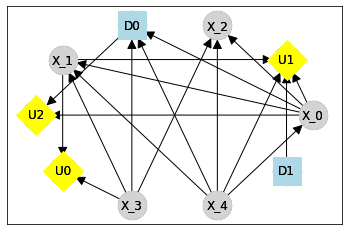

In [ ]:
cid.draw()

In [ ]:
macid = pycid.random_macid(
    number_of_nodes=12,
    agent_decisions_num=(1, 3),
    agent_utilities_num=(2, 2),
    add_cpds=False,
    sufficient_recall=False,
    edge_density=0.4,
    max_in_degree=5,
    max_resampling_attempts=1000,
)

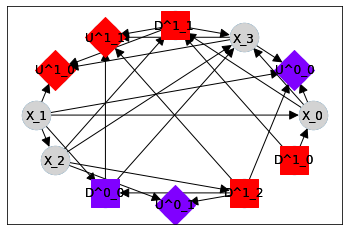

In [ ]:
macid.draw()

## References

Hammond, L., Fox, J., Everitt, T., Abate, A., & Wooldridge, M. (2021). Equilibrium Refinements for Multi-Agent Influence Diagrams: Theory and Practice. arXiv preprint arXiv:2102.05008.

J., Pearl. (2009) .Causality. Cambridge University Press, Cambridge, UK